In [5]:
import numpy as np
from Clasificador import Clasificador, ClasificadorRegresionLogistica, ClasificadorNaiveBayes
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

particionado = ValidacionSimple(0.2,50)
cl = ClasificadorRegresionLogistica()

data = Datos('wdbc.data', predNominal=True)

# cl.entrenamiento(data.datos,data.nominalAtributos,data.diccionario)
# y = cl.clasifica(data.datos,data.nominalAtributos,data.diccionario)

# print(y)
val = cl.validacion(particionado,data)
print("Media: ", np.mean(val))
print("Varianza: ", np.var(val))

C:\Users\David\Desktop\Universidad\FAA\Practicas\faa\p2\Clasificador.py:240: RuntimeWarning: overflow encountered in exp
  sig = lambda x: 1/(1+np.exp(-x))


Media:  0.16141592920353984
Varianza:  0.00994458454068447


In [4]:
import numpy as np
from Clasificador import Clasificador, ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

particionado = ValidacionSimple(0.8,20)
cl = ClasificadorVecinosProximos(5,distancia='euclidea',normaliza=False)

data = Datos('wdbc.data', predNominal=True)

# cl.entrenamiento(data.datos,data.nominalAtributos,data.diccionario)
# y = cl.clasifica(data.datos,data.nominalAtributos,data.diccionario)

# print(y)
val = cl.validacion(particionado,data)
print("Media: ", np.mean(val))
print("Varianza: ", np.var(val))

Media:  0.07659340659340659
Varianza:  7.886728655959425e-05


Pruebas scikit

In [13]:
#kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from Datos import Datos

import numpy as np

numP = 5

distancias = ['euclidean','manhattan','mahalanobis']

data = Datos('wdbc.data', predNominal=True)
X, y = data.datos[:,:-1].astype('float'), data.datos[:,-1].astype('int')

cov = np.cov(np.transpose(X))

for dist in distancias:
    if dist == 'mahalanobis':
        param = {'V': cov}
    else:
        param = None
    neigh = KNeighborsClassifier(n_neighbors=5, metric=dist, metric_params=param)
    err = 1 - cross_val_score(neigh,X,y,cv=numP)
    print('Distancia: ', dist)
    print('Error medio: ',np.mean(err),'\n')


Distancia:  euclidean
Error medio:  0.07205402887750349 

Distancia:  manhattan
Error medio:  0.06854525694767895 

Distancia:  mahalanobis
Error medio:  0.20034156186927493 



In [23]:
# Regresión log
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from Datos import Datos

import numpy as np

numP = 5


clf = SGDClassifier(alpha=0.1)
data = Datos('wdbc.data', predNominal=True)
X, y = data.datos[:,:-1].astype('float'), data.datos[:,-1].astype('int')

err = 1 - cross_val_score(clf,X,y,cv=numP)
print("Media: ",np.mean(err))

Media:  0.1264865704083217


Curvas ROC

Vecinos próximos (bien escrito)

In [2]:
# WDBC
import numpy as np
from Clasificador import ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

distancias = ['euclidea','manhattan','mahalanobis']
vecinos = [1,5,11,21]

header = ['Num. Vecinos'] + distancias

#Esto tarda en ejecutarse 10 minutos, yo aviso.
numEx = 20 #Número de ejecuciones por caso
propTest = 0.3 #Proporción de datos del testSet

particionado = ValidacionSimple(propTest,numEx)
data = Datos('wdbc.data', predNominal=True)

datosTablaN = [vecinos,]
datosTabla = [vecinos,]

for dist in distancias:
    lstN = []
    lst = []
    for k in vecinos:
        # Normalizado
        clN = ClasificadorVecinosProximos(k,distancia=dist)
        erroresN = clN.validacion(particionado,data)
        # Sin normalizar
        cl = ClasificadorVecinosProximos(k,distancia=dist,normaliza=False)
        errores = cl.validacion(particionado,data)
        # Añadimos a las columnas
        lstN.append(np.mean(erroresN))
        lst.append(np.mean(errores))
    datosTabla.append(lst)
    datosTablaN.append(lstN)

print('Sin normalizar:')
t = Table(datosTabla,names=header)
print(t)
print('\n')

print('Normalizando:')
tN = Table(datosTablaN,names=header)
print(tN)
        

Sin normalizar:
Num. Vecinos       euclidea           manhattan          mahalanobis    
------------ ------------------- ------------------- -------------------
           1 0.08823529411764706 0.08058823529411765 0.17647058823529413
           5 0.06852941176470588 0.06088235294117648 0.19911764705882354
          11 0.07352941176470587 0.06647058823529413 0.22911764705882356
          21 0.07029411764705883 0.07205882352941177 0.26794117647058824


Normalizando:
Num. Vecinos       euclidea           manhattan          mahalanobis    
------------ ------------------- ------------------- -------------------
           1 0.08441176470588235 0.07323529411764704 0.17705882352941174
           5 0.06294117647058824 0.06294117647058824 0.20294117647058824
          11 0.06764705882352941 0.06323529411764707 0.24647058823529414
          21 0.07235294117647059  0.0714705882352941 0.29264705882352937


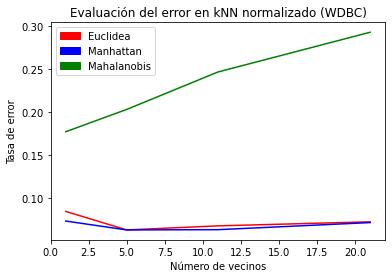

In [8]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

vecinos = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# Distancia euclidea
plt.plot(vecinos,datos[0],'r')
# Manhattan
plt.plot(vecinos,datos[1],'b')
# Mahalanobis
plt.plot(vecinos,datos[2],'g')

red = mpatches.Patch(color='red', label='Euclidea')
blue = mpatches.Patch(color='blue', label='Manhattan')
green = mpatches.Patch(color='green', label='Mahalanobis')

plt.legend(handles=[red,blue,green])
plt.xlabel('Número de vecinos')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en kNN normalizado (WDBC)')

plt.show()

In [1]:
# Diabetes
import numpy as np
from Clasificador import ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

distancias = ['euclidea','manhattan','mahalanobis']
vecinos = [1,5,11,21]

header = ['Num. Vecinos'] + distancias

#Esto tarda en ejecutarse 10 minutos, yo aviso.
numEx = 20 #Número de ejecuciones por caso
propTest = 0.3 #Proporción de datos del testSet

particionado = ValidacionSimple(propTest,numEx)
data = Datos('pima-indians-diabetes.data')

datosTablaN = [vecinos,]
datosTabla = [vecinos,]

for dist in distancias:
    lstN = []
    lst = []
    for k in vecinos:
        # Normalizado
        clN = ClasificadorVecinosProximos(k,distancia=dist)
        erroresN = clN.validacion(particionado,data)
        # Sin normalizar
        cl = ClasificadorVecinosProximos(k,distancia=dist,normaliza=False)
        errores = cl.validacion(particionado,data)
        # Añadimos a las columnas
        lstN.append(np.mean(erroresN))
        lst.append(np.mean(errores))
    datosTabla.append(lst)
    datosTablaN.append(lstN)

print('Sin normalizar:')
t = Table(datosTabla,names=header)
print(t)
print('\n')

print('Normalizando:')
tN = Table(datosTablaN,names=header)
print(tN)

Sin normalizar:
Num. Vecinos       euclidea          manhattan         mahalanobis    
------------ ------------------- ------------------ ------------------
           1  0.3267391304347826  0.312391304347826 0.3154347826086957
           5 0.28108695652173915 0.2639130434782609 0.2713043478260869
          11 0.27021739130434785 0.2517391304347826              0.265
          21  0.2639130434782609 0.2539130434782609 0.2623913043478261


Normalizando:
Num. Vecinos       euclidea           manhattan          mahalanobis    
------------ ------------------- ------------------- -------------------
           1  0.3206521739130435  0.3147826086956522  0.2960869565217391
           5 0.29347826086956524 0.27195652173913043  0.2691304347826088
          11 0.25565217391304346 0.25021739130434784 0.26608695652173914
          21 0.27326086956521733  0.2539130434782609                0.26


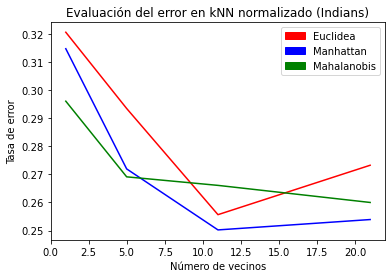

In [2]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

vecinos = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# Distancia euclidea
plt.plot(vecinos,datos[0],'r')
# Manhattan
plt.plot(vecinos,datos[1],'b')
# Mahalanobis
plt.plot(vecinos,datos[2],'g')

red = mpatches.Patch(color='red', label='Euclidea')
blue = mpatches.Patch(color='blue', label='Manhattan')
green = mpatches.Patch(color='green', label='Mahalanobis')

plt.legend(handles=[red,blue,green])
plt.xlabel('Número de vecinos')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en kNN normalizado (Indians)')

plt.show()

Regresión Logística

In [3]:
# WDBC
import numpy as np
from Clasificador import ClasificadorRegresionLogistica
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

constantes = [0.01,0.1,0.5,1,5,10,20]
pasos = [1,100,200]

header = ['Cte \ Pasos'] + pasos

numEx = 20 #Número de ejecuciones por caso
propTest = 0.3 #Proporción de datos del testSet

particionado = ValidacionSimple(propTest,numEx)
data = Datos('wdbc.data', predNominal=True)

datosTablaN = [constantes,]
datosTabla = [constantes,]

for paso in pasos:
    lstN = []
    lst = []
    for cte in constantes:
        # Normalizado
        clN = ClasificadorRegresionLogistica(eta=cte,epochs=paso)
        erroresN = clN.validacion(particionado,data)
        # Sin normalizar
        cl = ClasificadorRegresionLogistica(eta=cte,epochs=paso,normaliza=False)
        errores = cl.validacion(particionado,data)
        # Añadimos a las columnas
        lstN.append(np.mean(erroresN))
        lst.append(np.mean(errores))
    datosTabla.append(lst)
    datosTablaN.append(lstN)

print('Sin normalizar:')
t = Table(datosTabla,names=header)
print(t)
print('\n')

print('Normalizando:')
tN = Table(datosTablaN,names=header)
print(tN)

Sin normalizar:
Cte \ Pasos          1                  100                 200        
----------- ------------------- ------------------- -------------------
       0.01 0.20852941176470585 0.11205882352941177 0.13911764705882354
        0.1 0.32029411764705884  0.1608823529411765 0.10441176470588236
        0.5  0.1897058823529412 0.11911764705882352 0.12205882352941178
        1.0  0.2388235294117647 0.12441176470588236 0.12441176470588237
        5.0 0.32529411764705884 0.12058823529411763  0.1088235294117647
       10.0  0.3461764705882353 0.10676470588235294 0.10941176470588235
       20.0 0.36176470588235293 0.12470588235294118  0.1244117647058824


Normalizando:
Cte \ Pasos          1                  100                 200        
----------- ------------------- ------------------- -------------------
       0.01 0.23823529411764705 0.16441176470588237 0.11294117647058824
        0.1 0.17852941176470588  0.1255882352941176  0.1335294117647059
        0.5 0.28264705882352936 